## init

In [1]:
%load_ext autoreload
%autoreload 2
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mnist_utils as mu
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"


## AU2 train/val acc

In [30]:
import pandas as pd
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame(columns=["uncertainty","model","train_acc","test_acc","params"])

model_matches = ["MLP_", "CNN_"]
unc_matches_eq = ["AU2_EU"]

for filename in os.listdir(p):
    if filename.endswith(".pth"):
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        num_params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        n = len(data["checkpoints"])
        if not any([model_cfg.startswith(m) for m in model_matches]):
            continue
        if not any([m == unc_cfg for m in unc_matches_eq]):
            continue
        values = [unc_cfg,model_cfg, 
                [float(data["final_acc"][i]["train_acc"]) for i in range(n)], 
                [float(data["final_acc"][i]["test_acc"]) for i in range(n)], 
                num_params]
        df.loc[len(df)] = values
print(f"Found {len(df)} models")

Found 79 models


In [ ]:


#print(seq_type_from_name("MLP_aug0.2_H"))
# Add all stats to df. Add new columns if needed.
for i, row in df.iterrows():
    params = mu.seq_type_from_name(row["model"])
    for k,v in params.items():
        if k not in df.columns:
            df[k] = None
        df.at[i,k] = v

In [ ]:
# colors differentiate seq_types
# symbols differentiate model types

uq_model_types = sorted(df["model_type"].unique().tolist())
uq_seq_types = sorted(df["seq_type"].unique().tolist())

#only_show_seq_type = uq_seq_types
only_show_seq_type = ["aug_H","aug"]

add_text = True
show_means = True
connect_means = True

symbols = ["o", "s"]
cols = ["C3", "C1", "C2", "C0", "C4", "C5","C6"]
assert len(cols) >= len(uq_seq_types), f"Only {len(cols)} colors for {len(uq_seq_types)} sequence types"
assert len(symbols) >= len(uq_model_types), f"Only {len(symbols)} symbols for {len(uq_model_types)} model types"
plt.figure(figsize=(10,6))
for i,mt in enumerate(uq_model_types):
    for j,st in enumerate(uq_seq_types):
        if st not in only_show_seq_type:
            continue
        mask = (df["model_type"] == mt) & (df["seq_type"] == st)
        if np.sum(mask) == 0:
            continue
        sub_df = df[mask]
        assert len(set(sub_df["varying_param"])) == 1, f"Multiple varying params in {mt}, {st}. Found: {set(sub_df['varying_param'])}"

        # extract #[varying_param]x#[num_models] arrays for train_acc and test_acc
        train_accs = np.array(sub_df["train_acc"].tolist())
        test_accs = np.array(sub_df["test_acc"].tolist())
        param_name = sub_df["varying_param"].iloc[0]
        #expand to same size as train_accs/test_accs
        param_values = np.array(sub_df[param_name].tolist())[:,None].repeat(train_accs.shape[1], axis=1)
        
        if show_means:
            train_accs = train_accs.mean(axis=1)
            test_accs = test_accs.mean(axis=1)
            param_values = param_values.mean(axis=1)
            #sort by param_values
            sort_idx = np.argsort(param_values)
            train_accs = train_accs[sort_idx]
            test_accs = test_accs[sort_idx]
            param_values = param_values[sort_idx]
            if connect_means:
                #connect means with a line
                plt.plot(train_accs, test_accs, color=cols[j], marker=symbols[i], alpha=0.5, linewidth=1)
        plt.scatter(train_accs.flatten(), test_accs.flatten(),
                    color=cols[j], marker=symbols[i], s=200 if show_means else 100, alpha=0.7, edgecolor='k'
                )
        if add_text:
            # add param value as text in the center of each point
            param_values = param_values.astype(identifiers_inv[param_name][1])
            for k in range(len(train_accs.flatten())):
                s = str(param_values.flatten()[k])
                modif = 0.5+0.5/len(s)
                plt.text(train_accs.flatten()[k], test_accs.flatten()[k], s,
                        color='k', fontsize=12*modif, ha='center', va='center')
                

for j,model in enumerate(uq_model_types):
    plt.scatter([], [], color='k', marker=symbols[j], s=100, label=model)
for i,unc in enumerate(uq_seq_types):
    plt.scatter([], [], color=cols[i], marker='o', s=100, label=unc)
plt.xlabel("Training accuracy")
plt.ylabel("Test accuracy")
plt.legend(ncols=2)
#get current axis bounds
ax = plt.gca()
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
l1,l2 = min(x0,y0), max(x1,y1)
plt.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
plt.xlim(l1,l2), plt.ylim(l1,l2)
plt.grid()



## AU2 scatters

In [48]:
# READ IN ALL AU2 DATA
import pandas as pd
p = "/home/jloch/Desktop/diff/luzern/random_experiments/mnist/saves"

df = pd.DataFrame(columns=["unc_cfg","model_cfg","train_acc","test_acc","params",
                           'ece', 'ece_optnll', 'ece_optece', 'nll', 'nll_optnll', 'nll_optece', 'T_opt_nll', 'T_opt_ece',
                            "EU_auc", "AU_auc", "TU_auc", "EU_iid", "EU_ood", "AU_iid", "AU_ood", "TU_iid", "TU_ood",
                            "TU_rankcorr", "EU_rankcorr", "AU_rankcorr",
                             "mean_AU", "mean_EU", "mean_TU"
    ])
model_matches = ["MLP_", "CNN_"]
unc_matches_eq = ["AU2_EU"]
for filename in os.listdir(p):
    if filename.endswith(".pth"):
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        
        if not any([model_cfg.startswith(m) for m in model_matches]):
            continue
        if not any([m == unc_cfg for m in unc_matches_eq]):
            continue
        file_path = os.path.join(p, filename)
        data = torch.load(file_path, weights_only=False)
        n = len(data["checkpoints"])
        params = sum([v.numel() for v in data["checkpoints"][0].values()])
        unc_cfg,model_cfg = filename.replace(".pth","").split("__")
        value_dict = {"unc_cfg": unc_cfg, 
                    "model_cfg": model_cfg, 
                    "train_acc": sum([data["final_acc"][i]["train_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                    "test_acc": sum([data["final_acc"][i]["test_acc"] for i in range(len(data["final_acc"]))]) / len(data["final_acc"]),
                    "params": params,
                    "EU_auc": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["auc"],
                    "AU_auc": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["auc"],
                    "TU_auc": data["unc_stats"]["ood_stats"]["pred_entropy"]["auc"],
                    "EU_iid": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["iid_entropy"],
                    "EU_ood": data["unc_stats"]["ood_stats"]["epistemic_uncertainty"]["ood_entropy"],
                    "AU_iid": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["iid_entropy"],
                    "AU_ood": data["unc_stats"]["ood_stats"]["aleatoric_uncertainty"]["ood_entropy"],
                    "TU_iid": data["unc_stats"]["ood_stats"]["pred_entropy"]["iid_entropy"],
                    "TU_ood": data["unc_stats"]["ood_stats"]["pred_entropy"]["ood_entropy"],
                    "TU_rankcorr": data["unc_stats"]["amb_stats"]["pred_entropy"]["spearman_all"],
                    "EU_rankcorr": data["unc_stats"]["amb_stats"]["epistemic_uncertainty"]["spearman_all"],
                    "AU_rankcorr": data["unc_stats"]["amb_stats"]["aleatoric_uncertainty"]["spearman_all"],
                    "mean_AU": data["unc_stats"]["amb_stats"]["pred_entropy"]["mean_entropies"]["all"],
                    "mean_EU": data["unc_stats"]["amb_stats"]["epistemic_uncertainty"]["mean_entropies"]["all"],
                    "mean_TU": data["unc_stats"]["amb_stats"]["aleatoric_uncertainty"]["mean_entropies"]["all"],
                    }
        for k,v in data["unc_stats"]["calib_stats"].items():
            value_dict[k] = v
        for k,v in value_dict.items():
            if torch.is_tensor(v):
                value_dict[k] = float(v)
        value_list = [value_dict[col] for col in df.columns]
        df.loc[len(df)] = value_list


print(f"Found {len(df)} models")

Found 82 models


In [50]:
# Add all stats to df. Add new columns if needed.
for i, row in df.iterrows():
    params = mu.seq_type_from_name(row["model_cfg"])
    for k,v in params.items():
        if k not in df.columns:
            df[k] = None
        df.at[i,k] = v

df["EU_iid/AU_iid"] = df["EU_iid"] / df["AU_iid"]
df["EU_ood/AU_ood"] = df["EU_ood"] / df["AU_ood"]

In [5]:
print(sorted(df["seq_type"].unique().tolist()))

['aug', 'aug_H', 'channels', 'channels_aug', 'depth', 'depth_aug', 'epochs']


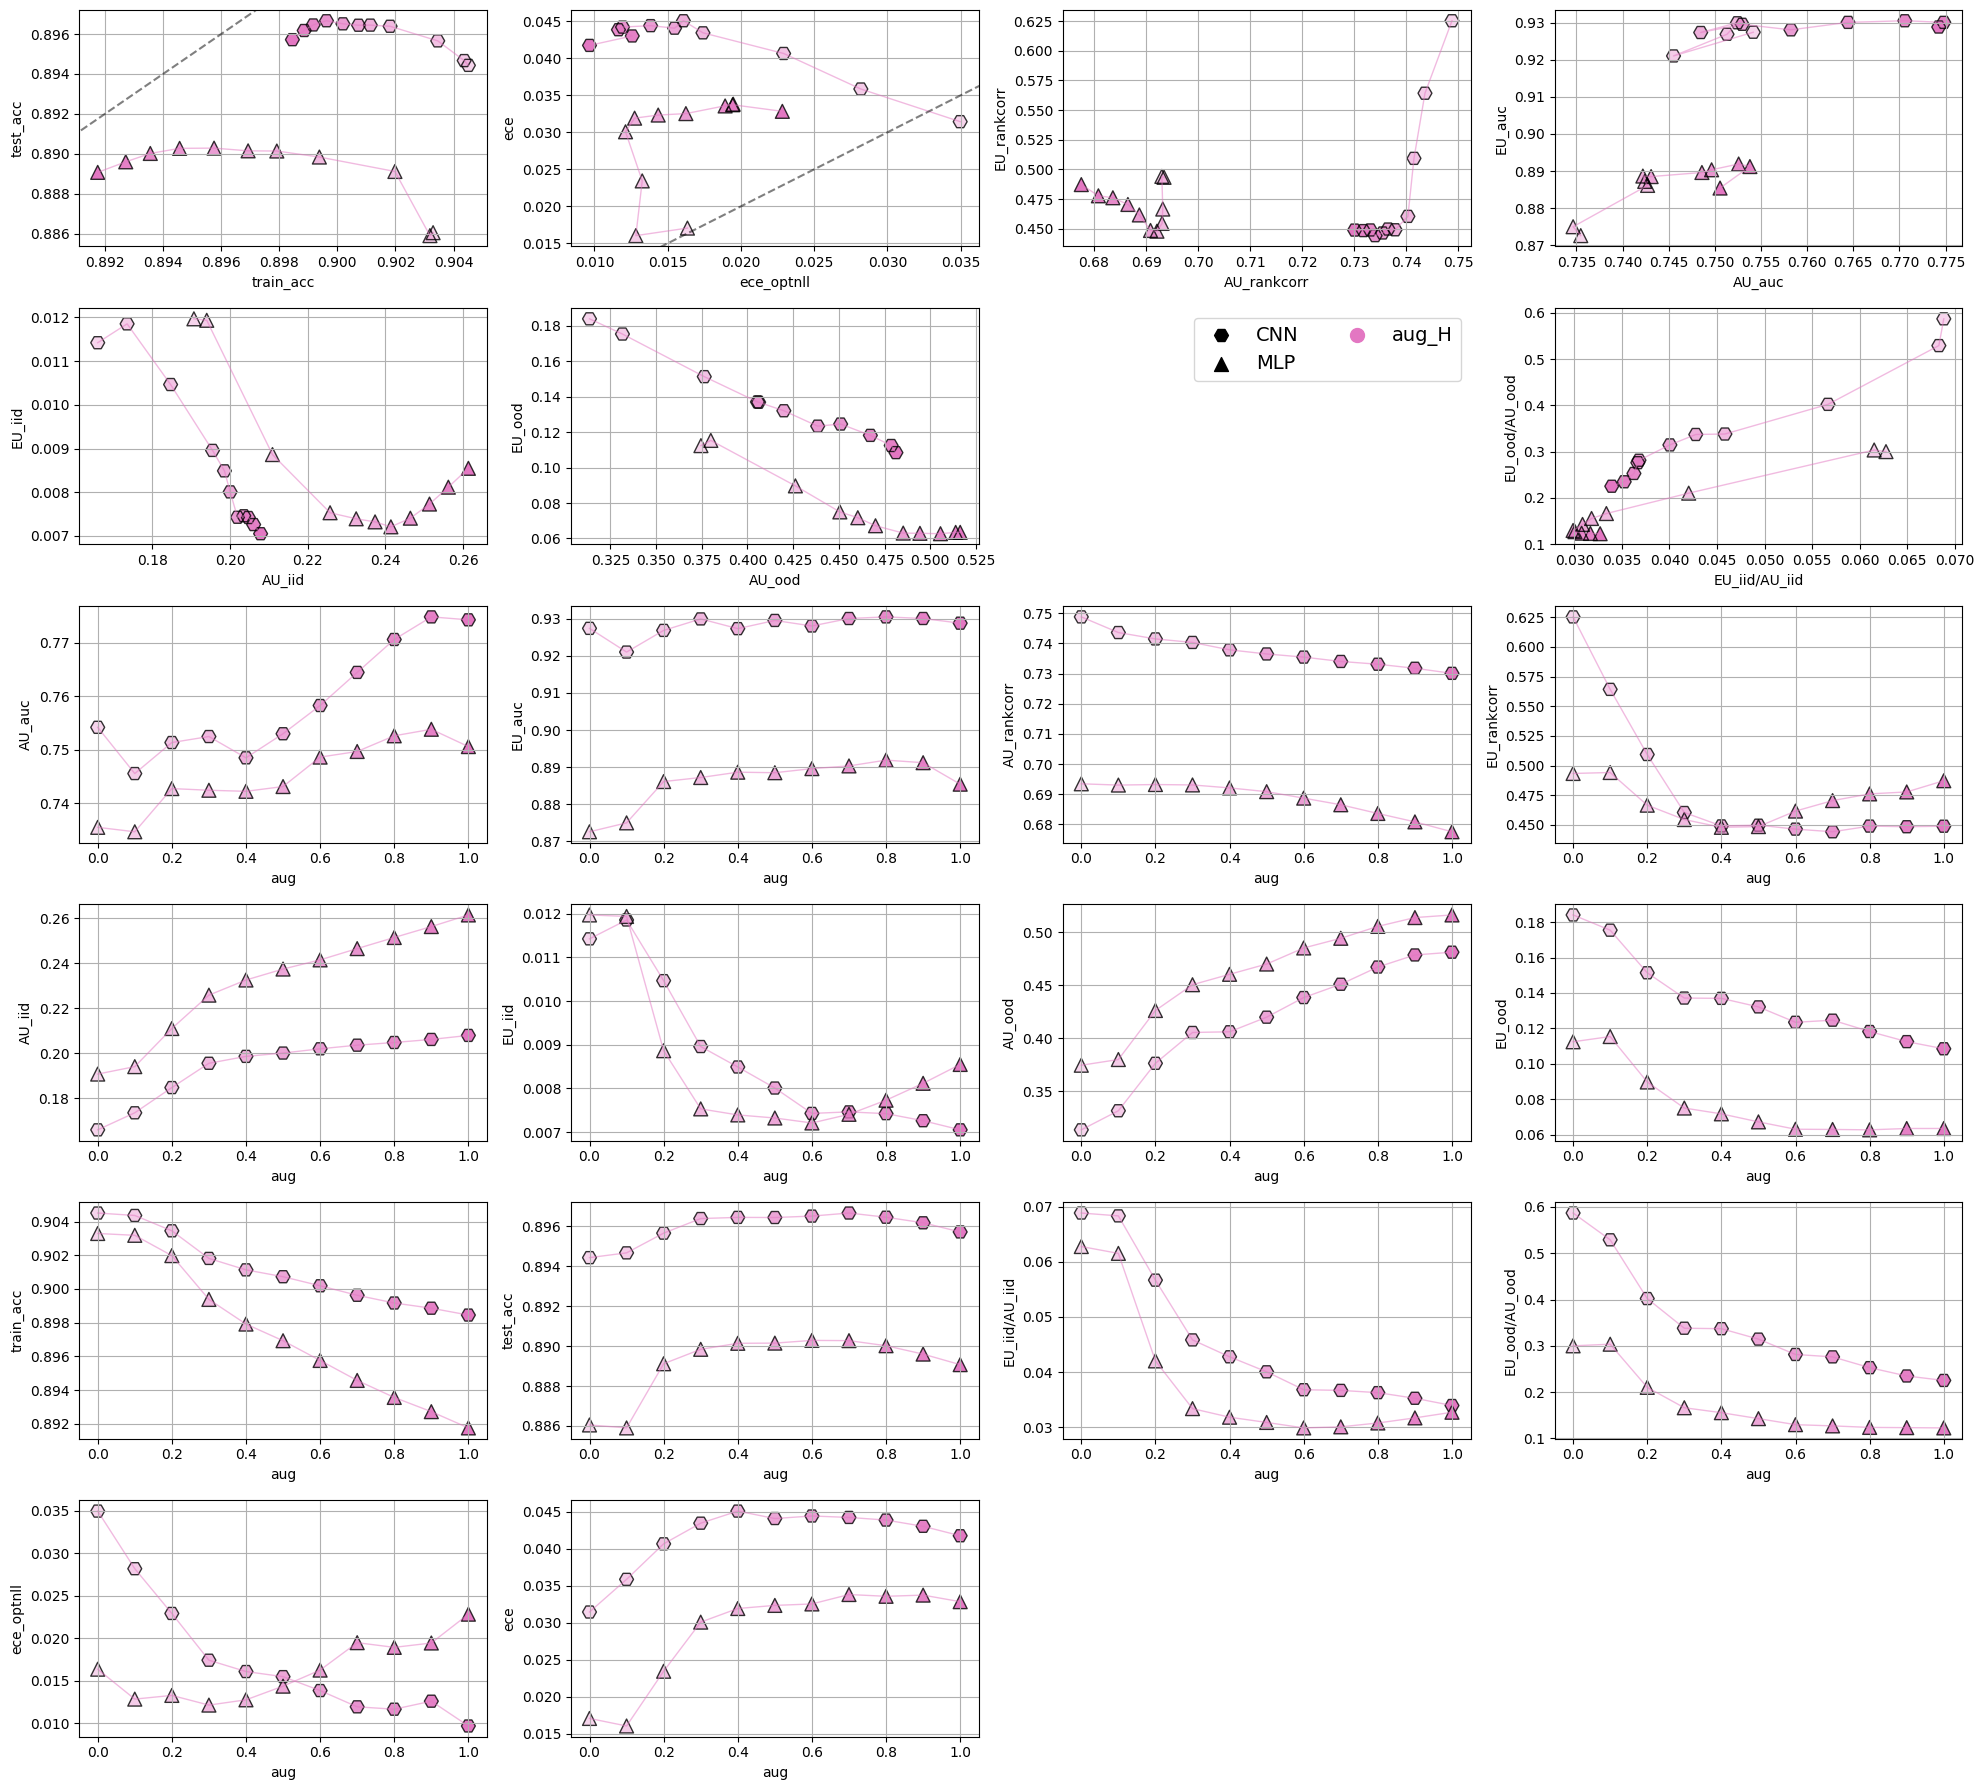

In [51]:
include_seq_types =  ["aug_H"] #['aug', 'aug_H', 'channels', 'channels_aug', 'depth', 'depth_aug', 'epochs']
#include_seq_types = uq_seq_types
default_options = {"logx": False, "logy": False, "add_x=y": False, "is_legend": False}
scatters = [["train_acc","test_acc", {"add_x=y": True}],    
            ["ece_optnll","ece", {"add_x=y": True}],
            ["AU_rankcorr","EU_rankcorr", {"add_x=y": True}],
            ["AU_auc","EU_auc", {"add_x=y": True}],
            ["AU_iid","EU_iid", {"add_x=y": True}],
            ["AU_ood","EU_ood", {"add_x=y": True}],
            ["","", {"is_legend": True}],
            ["EU_iid/AU_iid","EU_ood/AU_ood", {"add_x=y": True}]
            ]

connect_sequences = True
seq_variable = "aug"

comp_vars = ["AU_auc","EU_auc","AU_rankcorr","EU_rankcorr","AU_iid","EU_iid","AU_ood",
             "EU_ood","train_acc","test_acc","EU_iid/AU_iid","EU_ood/AU_ood",
             "ece_optnll","ece"]

for k in comp_vars:
    scatters.append([seq_variable, k, {"logx": 0,"logy": k in ["params"]}])


"""["AU_ood","EU_ood", {"logy": 0, "logx": 0, "add_x=y": True}],
            ["AU_rankcorr","test_acc", {}],
            ["AU_rankcorr","train_acc", {}],
            ["EU_rankcorr","test_acc", {}],
            ["EU_rankcorr","train_acc", {}],
            ["AU_auc","train_acc", {}],
            ["mean_AU",, {"add_x=y": True}],
            ["ece_optnll","ece", {"add_x=y": True}],"""

include_model_startswith = ["CNN","MLP"]
uq_seq_types = sorted(df["seq_type"].unique().tolist())

symbols = ['H', '^', "P","X", 'o', 'v', 's', 'D', '*']
cols2 = ["#006d77",  # deep teal
    "#daa520",  # goldenrod
    "#f08080",  # light coral
    "#4682b4",  # steel blue
    "#ba55d3",  # medium orchid
    "#2e8b57"  # sea green
]

cols = ["C7", "C6", "C2", "C3", "C1", "C0", "C8", "C9", "C4", "C5"]+cols2
subplots = (6,4)
assert len(scatters) <= subplots[0]*subplots[1], "Too many subplots for grid, add more rows/cols"
fig, axs = plt.subplots(subplots[0], subplots[1], figsize=(5*subplots[1],3*subplots[0]))
for i,(x_key,y_key,options) in enumerate(scatters):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    if options.get("is_legend", default_options["is_legend"]):
        handles = []
        for j,model in enumerate(include_model_startswith):
            handles.append(ax.scatter([], [], color='k', marker=symbols[j], s=100, label=model))
        for k,seq in enumerate(uq_seq_types):
            if seq in include_seq_types:
                handles.append(ax.scatter([], [], color=cols[k], marker='o', s=100, label=seq))
        ax.legend(handles=handles, ncol=2, fontsize=14)
        ax.axis('off')
        continue

    for j,model in enumerate(include_model_startswith):
        for k,seq in enumerate(uq_seq_types):
            if seq not in include_seq_types:
                continue
            
            mask = np.array(df["seq_type"] == seq) & np.array([item.startswith(model) for item in df["model_cfg"]])
            if np.sum(mask) == 0:
                continue
            
            seq_param = df[mask]["varying_param"].iloc[0]
            
            if connect_sequences:
                x = df.loc[mask, x_key]
                y = df.loc[mask, y_key]
                v = df.loc[mask, seq_param]
                sort_idx = np.argsort(v)
                x = x.iloc[sort_idx]
                y = y.iloc[sort_idx]
                ax.plot(x,y, color=cols[k], alpha=0.5, linewidth=1)
            max_varying = df.loc[mask, seq_param].max()
            min_varying = df.loc[mask, seq_param].min()
            strength = 0.3 + 0.7 * (df.loc[mask, seq_param] - min_varying) / (max_varying - min_varying + 1e-8)
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                    color=cols[k], marker=symbols[j], s=100, alpha=strength, edgecolor="none")
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                color="none", marker=symbols[j], s=100, alpha=0.8, edgecolor="k")
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.grid()
    #get current axis bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    l1,l2 = min(x0,y0), max(x1,y1)
    if x_key == y_key:
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(l1,l2), ax.set_ylim(l1,l2)
    if options.get("logx", default_options["logx"]):
        ax.set_xscale('log')
    if options.get("logy", default_options["logy"]):
        ax.set_yscale('log')
    if options.get("add_x=y", default_options["add_x=y"]):
        x1,x2,y1,y2 = ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]
        l1,l2 = min(x1,y1), max(x2,y2)
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(x1,x2), ax.set_ylim(y1,y2)
for i in range(len(scatters), subplots[0]*subplots[1]):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    ax.axis('off')
plt.tight_layout()

In [56]:
mu.get_epochs_models_heavy()

{'CNN_e100_H_aug0': {'model': 'models.CNNDeluxe',
  'epochs': 100,
  'model_args': {'base_channels': 32, 'num_blocks': 3, 'num_downsamples': 3}},
 'MLP_e100_H_aug0': {'model': 'models.MLPDeluxe',
  'epochs': 100,
  'model_args': {'width': 256, 'num_layers': 8}},
 'CNN_e100_H_aug1': {'model': 'models.CNNDeluxe',
  'epochs': 100,
  'model_args': {'base_channels': 32, 'num_blocks': 3, 'num_downsamples': 3},
  'data_aug': 1},
 'MLP_e100_H_aug1': {'model': 'models.MLPDeluxe',
  'epochs': 100,
  'model_args': {'width': 256, 'num_layers': 8},
  'data_aug': 1}}

In [ ]:
default_options = {"logx": False, "logy": False, "add_x=y": False, "is_legend": False}
scatters = [["train_acc","test_acc", {"add_x=y": True}],    
            ["ece_optnll","ece_optece", {"add_x=y": True}],
            ["AU_rankcorr","EU_rankcorr", {"add_x=y": True}],
            ["AU_auc","EU_auc", {"add_x=y": True}],
            ["AU_iid","EU_iid", {"add_x=y": True}],
            ["","", {"is_legend": True}],
            ["AU_ood","EU_ood", {"logy": 0, "logx": 0, "add_x=y": True}],
            ["AU_rankcorr","test_acc", {}],
            ["AU_rankcorr","train_acc", {}],
            ["EU_rankcorr","test_acc", {}],
            ["EU_rankcorr","train_acc", {}],
            ["AU_auc","train_acc", {}],
            ["mean_AU","mean_EU", {"add_x=y": True}],
            ["ece_optnll","ece", {"add_x=y": True}],
            ]


include_seq_types =  ["channels","channels_aug"] #['aug', 'aug_H', 'channels', 'channels_aug', 'depth', 'depth_aug', 'epochs']
include_model_startswith = ["CNN","MLP"]
uq_seq_types = sorted(df["seq_type"].unique().tolist())

symbols = ['H', '^', "P","X", 'o', 'v', 's', 'D', '*']
cols2 = ["#006d77",  # deep teal
    "#daa520",  # goldenrod
    "#f08080",  # light coral
    "#4682b4",  # steel blue
    "#ba55d3",  # medium orchid
    "#2e8b57"  # sea green
]

cols = ["C3", "C2", "C1", "C4", "C0", "C5", "C6", "C7", "C8", "C9"]+cols2
subplots = (4,4)
assert len(scatters) <= subplots[0]*subplots[1], "Too many subplots for grid, add more rows/cols"
fig, axs = plt.subplots(subplots[0], subplots[1], figsize=(5*subplots[1],3*subplots[0]))
for i,(x_key,y_key,options) in enumerate(scatters):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    if options.get("is_legend", default_options["is_legend"]):
        handles = []
        for j,model in enumerate(include_model_startswith):
            handles.append(ax.scatter([], [], color='k', marker=symbols[j], s=100, label=model))
        for k,seq in enumerate(include_seq_types):
            handles.append(ax.scatter([], [], color=cols[k], marker='o', s=100, label=seq))
        ax.legend(handles=handles, ncol=2)
        ax.axis('off')
        continue

    for j,model in enumerate(include_model_startswith):
        for k,seq in enumerate(include_seq_types):
            mask = np.array(df["seq_type"] == seq) & np.array([item.startswith(model) for item in df["model_cfg"]])
            if np.sum(mask) == 0:
                continue
            seq_param = df[mask]["varying_param"].iloc[0]
            max_varying = df.loc[mask, seq_param].max()
            min_varying = df.loc[mask, seq_param].min()
            strength = 0.3 + 0.7 * (df.loc[mask, seq_param] - min_varying) / (max_varying - min_varying + 1e-8)
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                    color=cols[k], marker=symbols[j], s=100, alpha=strength, edgecolor="none")
            ax.scatter(df.loc[mask, x_key], df.loc[mask, y_key],
                color="none", marker=symbols[j], s=100, alpha=0.8, edgecolor="k")
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.grid()
    #get current axis bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    l1,l2 = min(x0,y0), max(x1,y1)
    if x_key == y_key:
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(l1,l2), ax.set_ylim(l1,l2)
    if options.get("logx", default_options["logx"]):
        ax.set_xscale('log')
    if options.get("logy", default_options["logy"]):
        ax.set_yscale('log')
    if options.get("add_x=y", default_options["add_x=y"]):
        x1,x2,y1,y2 = ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]
        l1,l2 = min(x1,y1), max(x2,y2)
        ax.plot([l1,l2],[l1,l2], 'k--', alpha=0.5)
        ax.set_xlim(x1,x2), ax.set_ylim(y1,y2)
for i in range(len(scatters), subplots[0]*subplots[1]):
    ax = axs[i//subplots[1], i%subplots[1]] if subplots[0]>1 else axs[i%subplots[1]]
    ax.axis('off')
plt.tight_layout()

## train

In [67]:
model = mu.get_models_dict(tsne=0)["MLP0"]()
train_dl, val_dl = mu.get_dataloaders(ignore_digits=[2,3,5], augment=False, batch_size=256, ambiguous_vae_samples=0)
history = mu.train(model, train_dl, val_dl, epochs=20, lr=1e-4, weight_decay=0.0, cosine_anneal_epochs=20, soft_labels=False)

Training:   0%|          | 0/3320 [00:00<?, ?it/s]

In [69]:
for k,v in history["model_epochs"].items():
    print("key:", k)
    tensors = v.values()
    #print squared sum of all params
    squared_sum = sum([torch.sum(v**2).item() for v in tensors])
    print(squared_sum)

key: 5
316.00824916851707
key: 10
321.4190921164118
key: 15
323.7894385755062
key: 20
324.21231906767935
